In [2]:
%cd ../../..

/home/pristalovya/Inter/Programming/nlp-coursework


In [3]:
from src.nlp.application import (Pipeline, 
                                 get_df_by_film_and_person, 
                                 get_df_by_person, 
                                 collect_sents_to_summarize,
                                 split_opinions_to_chunks)
from datasets_ import DatasetLoader

import dill
from tqdm.notebook import tqdm
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib notebook


from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/pristalovya/Inter/linux_packages/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
data = DatasetLoader.load_named_entities_dataset(show_path=True)
data

/home/pristalovya/Inter/Programming/nlp-coursework/data/named_entities.csv


,ne,occurrences,film_id,n_sents
0,Кинг,[Несколько лет назад прочитала оригинальный ро...,435,150
1,Дарабонт,[После взросления и прочтения книги фильм Дара...,435,65
2,Перси,[Особенно нелепа вся эта линия с травлей Перси...,435,93
3,Депрессия,"[За то, что работает по блату (во времена Депр...",435,1
4,Делакруа,"[И кстати, ради большей слезовыжималки сценари...",435,26
...,...,...,...,...
106669,Сергей Эйзенштейн,[В качестве наглядного примера могу предложить...,969760,1
106670,Ферруччо,[Молодой Ферруччо - типичный англо-саксонский ...,969760,9
106671,Эдуардо де Филиппо,[Авторам смотреть старые итальянские фильмы и ...,969760,1
106672,Ютюба,[И он по законам мотивашек с Ютюба читает как ...,969760,1


In [16]:
print('Number of model input tokens:', len(tokenizer.convert_ids_to_tokens(tokenizer(opinions).input_ids)))
print('Word count:', len(opinions.split()))

Token indices sequence length is longer than the specified maximum sequence length for this model (4910 > 1024). Running this sequence through the model will result in indexing errors


Number of model input tokens: 4910
Word count: 2460


Overall number of sentences: 842
Number of chunks: 55


<IPython.core.display.Javascript object>


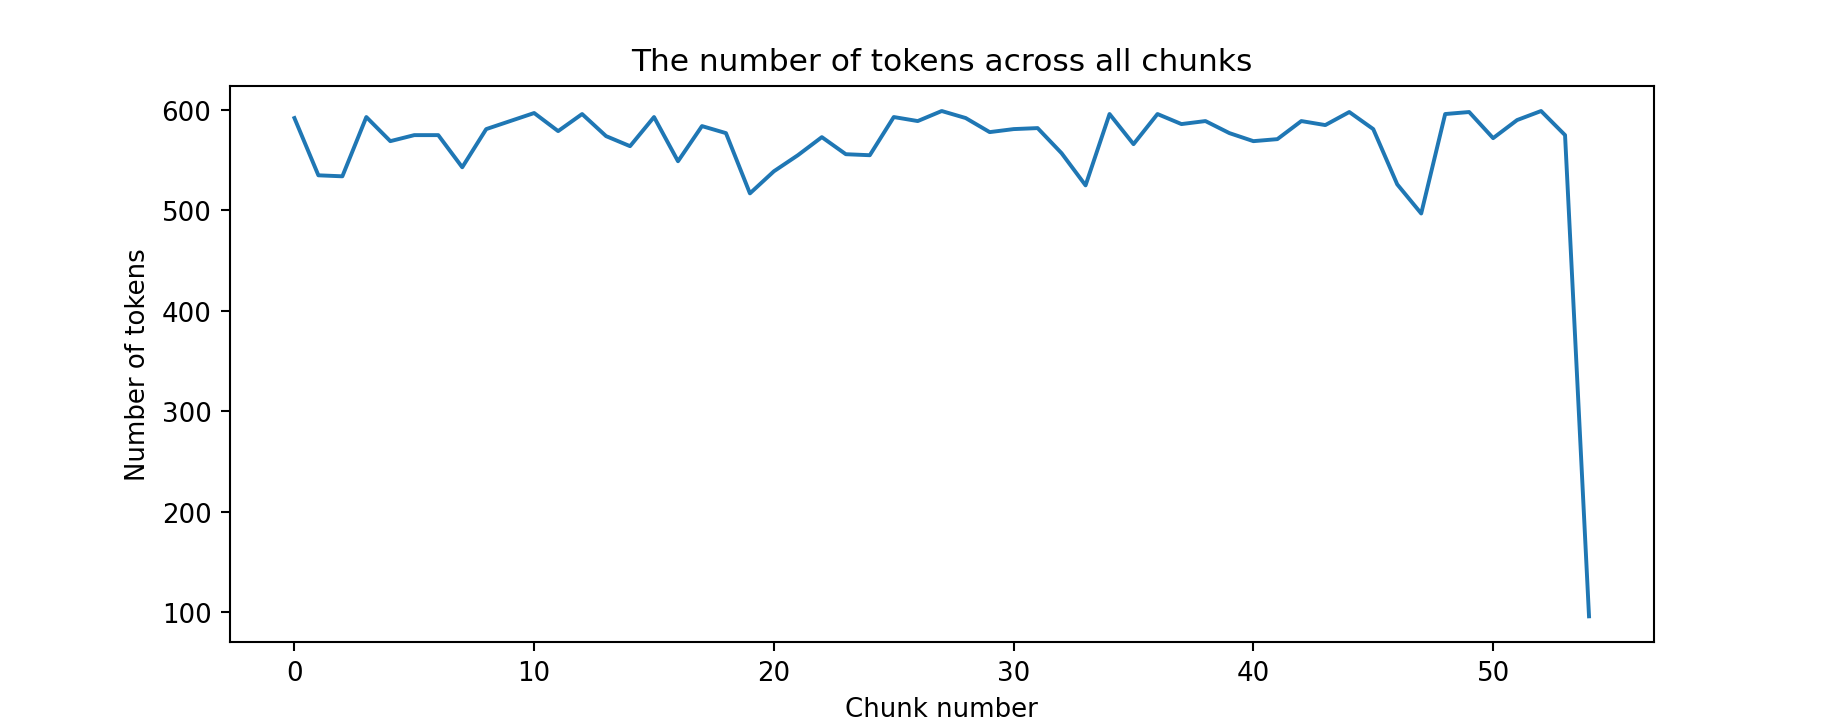

In [10]:
chunks = split_opinions_to_chunks(
    tokenizer=tokenizer, 
#     sentences=listed_opinions,
    data = get_df_by_person(data, 'хэтэуэй'),
    show_info=True
)

In [5]:
chunks = split_opinions_to_chunks(
    tokenizer=tokenizer, 
    sentences=collect_sents_to_summarize(get_df_by_person(data, 'хэтэуэй'), 
                                         n_sents = 100),
#     data = get_df_by_person(data, 'хэтэуэй'),
    show_info=False
)

#### Summarization by mBART

In [4]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

In [6]:
summarized = []
for chunk in chunks:
    input_ids = tokenizer(
        [chunk],
        max_length=600,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        no_repeat_ngram_size=4,
        max_new_tokens=200
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    summarized.append(summary)
    print(summary, end='\n\n')


В российском прокате «Тёмный рыцарь» Энн Хэтэуэй и Мэтью МакКонахи в роли Женщины-кошки.

В российском прокате «Энн Хэтэуэй» — новый фильм нолановской трилогии, в котором она сыграла Белую Королеву.

В российском прокате «Энн Хэтэуэй» — одна из самых интересных ролей в истории Голливуда. На этот раз она сыграла Белую Королеву в роли маленькой принцессы.

Энн Хэтэуэй, Мэрил Стрип, Стэнли Туччи, Маккензи Фой, Жизель Бюндхен и другие: что посмотреть в кино в эти выходные.

В российском прокате «Дьявол носит prada» — комедийный триллер с Энн Хэтэуэй и Мэттью МакКонахи в главной роли.

Энн Хэтэуэй, Маккензи Фой, Майкл Кейн, Джонни Депп и Мэтт Дэймон — что посмотреть в кино на этой неделе.

В российский прокат выходит «Энн Хэтэуэй» — фильм, в котором Амелия Бренд сыграет Белую королеву, а Энн МакКонахи — покорительницу космической бездны.

В российском прокате «Энн Хэтэуэй. Белая королева» — комедийный триллер с Хеленом Бонем Картер в главной роли.

В российском прокате «Эн Хэтэуэй» — трилог

In [7]:
len(tokenizer.encode(' '.join(summarized)))

381

In [8]:
input_ids = tokenizer(
    [' '.join(summarized)],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4,
    max_new_tokens=200
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
summarized.append(summary)
print(summary, end='\n\n')


В российский прокат выходит «Тёмный рыцарь» Энн Хэтэуэй и Мэтью МакКонахи в роли Женщины-кошки. Амелия Бренд сыграет Белую королеву, а Мэтт Дэймон — покорительницу космической бездны.



#### Summarization by ruT5 

In [12]:
model_name = "IlyaGusev/rut5_base_sum_gazeta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [13]:
summarized = []
for chunk in chunks:
    input_ids = tokenizer(
        [chunk],
        max_length=600,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        no_repeat_ngram_size=4,
        max_new_tokens=200
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    summarized.append(summary)
    print(summary, end='\n\n')


В российский прокат выходит «Тёмный рыцарь», в котором Энн Хэтэуэй играет женщину-кошку, Марийон Котийяр в роли богатой благодетельницы, Джозеф Горден-Левитт в роли молодого офицера полиции и Мэтью МакКонахи.

На этой неделе я посмотрел фильм «Интерстеллар», в котором Энн Хэтэуэй сыграла роль женщины-кошки в роли Белой королевы, а также в образе хитрой воровки и соблазнительной воровки с инстинктами кошки.

Мне было очень приятно видеть маленькую принцессе Энн Хэтэуэй в роли воровки Селины Кайл, Кошки, Которая Гуляет Сама По Себе.

В российский прокат выходит фильм «Энн Хэтэуэй - Белая королева», в котором Мэрил Стрип сыграла одну из главных ролей.

В российский прокат вышел фильм «Дьявол носит prada», в котором Энн Хэтэуэй исполнила одну из главных ролей.

Бокс-офис США: Энн Хэтэуэй стала женщиной-кошкой, Маккензи Фой великолепно отыграла своего персонажа, а Майкл Кейн сыграл хитрого старика-ученого.

В российский прокат выходит «Интерстеллар» Энн Хэтэуэй — женщина-кошка образца XXI в

In [14]:
len(tokenizer.encode(' '.join(summarized)))

469

In [15]:
input_ids = tokenizer(
    [' '.join(summarized)],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4,
    max_new_tokens=200
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
summarized.append(summary)
print(summary, end='\n\n')


В российский прокат выходит фильм «Интерстеллар», в котором Энн Хэтэуэй сыграла женщину-кошку, а Мэрил Стрип сыграла одну из главных ролей.



#### Summarization by FRED-T5 

In [6]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
chunks = split_opinions_to_chunks(
    tokenizer=tokenizer, 
    sentences=collect_sents_to_summarize(get_df_by_person(data, 'хэтэуэй'), 
                                         n_sents = 100),
#     data = get_df_by_person(data, 'хэтэуэй'),
    show_info=False
)

In [10]:
summarized = []
for chunk in chunks:
    input_ids = tokenizer(
        [chunk],
        max_length=600,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        no_repeat_ngram_size=4,
        # max_new_tokens=200
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    summarized.append(summary)
    print(summary, end='\n\n')


/home/pristalovya/Inter/linux_packages/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Энн Хэтэуэй в роли Женщины-Кошки, Марийон Котийяр

 Энн Хэтэуэй, которая сыграла роль Алисы, и Миа Васиковска

 Энн Хэтэуэй, Хелен Бонем Картер, Мия Васиковски, Джонни

, и это не смотря на то, что в фильме есть и другие актеры, но они не

<i>'Марсианин.'</i></b>



, но и не менее очаровательна.

<b>7 из 10</b




KeyboardInterrupt



#### Initial DataFrame representation

In [29]:
pers_data = get_df_by_person(data, 'хэтэуэй')
pers_data

,ne,occurrences,film_id,n_sents
29267,Энн Хэтэуэй,"[Энн Хэтэуэй в роли Селины Кайл — своенравная,...",437410,241
2575,Энн Хэтэуэй,"[Энн Хэтэуэй, Джессика Честейн, Маккензи Фой -...",258687,182
61410,Энн Хэтэуэй,[Ну и можно отметить <b>Энн Хэтэуэй</b> в роли...,405609,165
82788,Энн Хэтэуэй,[Но все же в исполнении Энн Хэтэуэй эта истори...,104992,99
29271,Хэтэуэй,[Все сцены с участием Хэтэуэй очень живые и ди...,437410,48
2713,Хэтэуэй,"[В ту любовь, что испытывала героиня Хэтэуэй п...",258687,28
62809,Энн Хэтэуэй,"[Далее Красавица - Энн Хэтэуэй, её печаль, как...",723988,16
61675,Хэтэуэй,"[Хэтэуэй вообще показалась не в теме., Хэтэуэй...",405609,14
82880,Хэтэуэй,"[Её безграничной надменности, сухости противос...",104992,13
62303,Энн Хэтэуэй),[Белая королева (Энн Хэтэуэй) показалась слишк...,405609,2
